<div style="background-color:rgba(0, 167, 255, 0.6);border-radius:5px;display:fill">
    <h1><center>Tabular Playground Series - March 2022</center></h1>
</div>

We need to forecast twelve-hours of traffic flow in a major U.S. metropolitan area. Time, space, and directional features are given and our job is to model the congestion of the future timesteps. 

Using standard validation techniques are not valid because of two aspects 
1) The data is time series. Our objective is to forecast future traffic conjestion, not past. Hence dividing data randomly is not valid, as test data should only have future data.

2) The traffice congention is measured at different places and there is no clear correlation between them. Dividing the data between train and test using simple timeseries split might also not be valid. Because the training model might miss data from some groups. 

**In summary the cross validation model should be able to use past information to predict future information for each group. GroupTimeSeriesSplit technique can be an excellent approach to handle such situations** 

**Full details can be found <a href="https://www.kaggle.com/code/jorijnsmit/found-the-holy-grail-grouptimeseriessplit/notebook">here</a>* and  <a  href=" https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243">here</a>  
The idea is basically to sort the data by time, group the observations according to time variable and then just build cross-validator the same way TimeSeriesSplit does, but on the newly formed groups of observations.

As @getgaurav2 & xcc explained
"Provides train/test indices to split time series data samples that are observed at fixed time intervals according to a    third-party provided group. In each split, test indices must be higher than before, and thus shuffling in cross validator is inappropriate. This cross-validation object is a variation of :class:`KFold`. In the kth split, it returns first k folds as train set and the (k+1)th fold as test set. The same group will not appear in two different folds (the number of
distinct groups has to be at least equal to the number of folds). Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them".

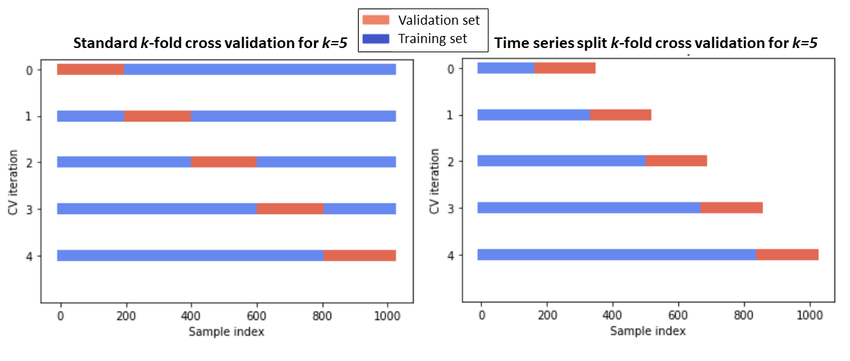

Ref: DOI:10.2478/erfin-2021-0006


All the credit goes to original works, I am only the enduser of this excellent technique.

In this notebook, I have applied GroupTimeSeriesSplit concept to one of the public <a href="https://www.kaggle.com/code/hasanbasriakcay/tps-mar22-pycaret-model-comparison">notebook</a> which was built using pycaret libary. I had noticed that the LB score imporved and model becomes more robust.  


<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>EDA and Feature Engineering</center></h1>
</div>

Here I have applied  the indept EDA, see the work of Martynov Andrey and this notebook <a href="https://www.kaggle.com/code/hasanbasriakcay/tps-mar22-pycaret-model-comparison">notebook</a>  for full details

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from matplotlib_venn import venn2_unweighted   
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [ ]:
#Thanks to @ambrosm and @MartynovAndrey
df_train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv', index_col="row_id", parse_dates=['time'])
df_test = pd.read_csv('../input/tabular-playground-series-mar-2022/test.csv', index_col="row_id", parse_dates=['time'])
def add_datetime_features(df):
    df['month']   = df['time'].dt.month
    df['day']     = df['time'].dt.day
    df['weekday'] = df['time'].dt.weekday
    df['weekend'] = (df['time'].dt.weekday >= 5)
    df['hour']    = df['time'].dt.hour
    df['minute']  = df['time'].dt.minute
    df['afternoon'] = df['hour'] >= 12
    
    # number of 20' period in a day
    df['moment']  = df['time'].dt.hour * 3 + df['time'].dt.minute // 20 
df_train['road'] = df_train['x'].astype(str) + df_train['y'].astype(str) + df_train['direction']
df_test['road']  = df_test['x'].astype(str) + df_test['y'].astype(str) + df_test['direction']

le = LabelEncoder()
df_train['road'] = le.fit_transform(df_train['road'])
df_test['road']  = le.transform(df_test['road'])

df_train = df_train.drop(['x', 'y', 'direction'], axis=1)
df_test = df_test.drop(['x', 'y', 'direction'], axis=1)

add_datetime_features(df_train)
add_datetime_features(df_test)
medians = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.median().astype(int)).reset_index()
medians = medians.rename(columns={'congestion':'median'})
df_train = df_train.merge(medians, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(medians, on=['road', 'weekday', 'hour', 'minute'], how='left')
mins = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.min().astype(int)).reset_index()
mins = mins.rename(columns={'congestion':'min'})
df_train = df_train.merge(mins, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(mins, on=['road', 'weekday', 'hour', 'minute'], how='left')
maxs = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.max().astype(int)).reset_index()
maxs = maxs.rename(columns={'congestion':'max'})
df_train = df_train.merge(maxs, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(maxs, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_mornings = df_train[(df_train.hour >= 6) & (df_train.hour < 12)]
morning_avgs = pd.DataFrame(df_mornings.groupby(['month', 'day', 'road']).congestion.median().astype(int)).reset_index()
morning_avgs = morning_avgs.rename(columns={'congestion':'morning_avg'})
df_train = df_train.merge(morning_avgs, on=['month', 'day', 'road'], how='left')
df_test = df_test.merge(morning_avgs, on=['month', 'day', 'road'], how='left')
df_train.time = pd.to_datetime(df_train.time)
df_train['time_id'] = ( ( (df_train.time.dt.dayofyear-1)*24*60 + df_train.time.dt.hour*60 + df_train.time.dt.minute ) /20 ).astype(int)
#df_train.drop(columns=['time','moment'],axis=1, inplace=True)
#df_train.drop(columns=['time'],axis=1, inplace=True)
df_train["weekend"] = df_train["weekend"].astype('category')
df_train["afternoon"] = df_train["afternoon"].astype('category')
df_test["weekend"] = df_test["weekend"].astype('category')
df_test["afternoon"] = df_test["afternoon"].astype('category')
# extracting time information from testing dataset
df_test.time = pd.to_datetime(df_test.time)
df_test['time_id'] = ( ( (df_test.time.dt.dayofyear-1)*24*60 + df_test.time.dt.hour*60 + df_test.time.dt.minute ) /20 ).astype(int)
prediction_steps = df_test['time_id'].nunique()  

### quick recap on the data we have generated using feature engineering

In [ ]:
df_test.head(3)

In [ ]:
df_train.head(3)

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center> The Magic - GroupTimeSeriesSplit</center></h1>
</div>

In [ ]:
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args


from collections import Counter, defaultdict

import numpy as np

from sklearn.model_selection._split import _BaseKFold, _RepeatedSplits
from sklearn.utils.validation import check_random_state


class StratifiedGroupKFold(_BaseKFold):
    """Stratified K-Folds iterator variant with non-overlapping groups.

    This cross-validation object is a variation of StratifiedKFold that returns
    stratified folds with non-overlapping groups. The folds are made by
    preserving the percentage of samples for each class.

    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).

    The difference between GroupKFold and StratifiedGroupKFold is that
    the former attempts to create balanced folds such that the number of
    distinct groups is approximately the same in each fold, whereas
    StratifiedGroupKFold attempts to create folds which preserve the
    percentage of samples for each class.

    Read more in the :ref:`User Guide <cross_validation>`.

    Parameters
    ----------
    n_splits : int, default=5
        Number of folds. Must be at least 2.

    shuffle : bool, default=False
        Whether to shuffle each class's samples before splitting into batches.
        Note that the samples within each split will not be shuffled.

    random_state : int or RandomState instance, default=None
        When `shuffle` is True, `random_state` affects the ordering of the
        indices, which controls the randomness of each fold for each class.
        Otherwise, leave `random_state` as `None`.
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.

    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import StratifiedGroupKFold
    >>> X = np.ones((17, 2))
    >>> y = np.array([0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    >>> groups = np.array([1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 5, 5, 6, 6, 7, 8, 8])
    >>> cv = StratifiedGroupKFold(n_splits=3)
    >>> for train_idxs, test_idxs in cv.split(X, y, groups):
    ...     print("TRAIN:", groups[train_idxs])
    ...     print("      ", y[train_idxs])
    ...     print(" TEST:", groups[test_idxs])
    ...     print("      ", y[test_idxs])
    TRAIN: [2 2 4 5 5 5 5 6 6 7]
           [1 1 1 0 0 0 0 0 0 0]
     TEST: [1 1 3 3 3 8 8]
           [0 0 1 1 1 0 0]
    TRAIN: [1 1 3 3 3 4 5 5 5 5 8 8]
           [0 0 1 1 1 1 0 0 0 0 0 0]
     TEST: [2 2 6 6 7]
           [1 1 0 0 0]
    TRAIN: [1 1 2 2 3 3 3 6 6 7 8 8]
           [0 0 1 1 1 1 1 0 0 0 0 0]
     TEST: [4 5 5 5 5]
           [1 0 0 0 0]

    See also
    --------
    StratifiedKFold: Takes class information into account to build folds which
        retain class distributions (for binary or multiclass classification
        tasks).

    GroupKFold: K-fold iterator variant with non-overlapping groups.
    """

    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        super().__init__(n_splits=n_splits, shuffle=shuffle,
                         random_state=random_state)

    # Implementation based on this kaggle kernel:
    # https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation
    def _iter_test_indices(self, X, y, groups):
        labels_num = np.max(y) + 1
        y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
        y_distr = Counter()
        for label, group in zip(y, groups):
            y_counts_per_group[group][label] += 1
            y_distr[label] += 1

        y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
        groups_per_fold = defaultdict(set)

        groups_and_y_counts = list(y_counts_per_group.items())
        rng = check_random_state(self.random_state)
        if self.shuffle:
            rng.shuffle(groups_and_y_counts)

        for group, y_counts in sorted(groups_and_y_counts,
                                      key=lambda x: -np.std(x[1])):
            best_fold = None
            min_eval = None
            for i in range(self.n_splits):
                y_counts_per_fold[i] += y_counts
                std_per_label = []
                for label in range(labels_num):
                    std_per_label.append(np.std(
                        [y_counts_per_fold[j][label] / y_distr[label]
                         for j in range(self.n_splits)]))
                y_counts_per_fold[i] -= y_counts
                fold_eval = np.mean(std_per_label)
                if min_eval is None or fold_eval < min_eval:
                    min_eval = fold_eval
                    best_fold = i
            y_counts_per_fold[best_fold] += y_counts
            groups_per_fold[best_fold].add(group)

        for i in range(self.n_splits):
            test_indices = [idx for idx, group in enumerate(groups)
                            if group in groups_per_fold[i]]
            yield test_indices
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class GroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_size : int, default=None
        Maximum size for a single training set.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import GroupTimeSeriesSplit
    >>> groups = np.array(['a', 'a', 'a', 'a', 'a', 'a',\
                           'b', 'b', 'b', 'b', 'b',\
                           'c', 'c', 'c', 'c',\
                           'd', 'd', 'd'])
    >>> gtss = GroupTimeSeriesSplit(n_splits=3)
    >>> for train_idx, test_idx in gtss.split(groups, groups=groups):
    ...     print("TRAIN:", train_idx, "TEST:", test_idx)
    ...     print("TRAIN GROUP:", groups[train_idx],\
                  "TEST GROUP:", groups[test_idx])
    TRAIN: [0, 1, 2, 3, 4, 5] TEST: [6, 7, 8, 9, 10]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a']\
    TEST GROUP: ['b' 'b' 'b' 'b' 'b']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] TEST: [11, 12, 13, 14]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b']\
    TEST GROUP: ['c' 'c' 'c' 'c']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]\
    TEST: [15, 16, 17]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c']\
    TEST GROUP: ['d' 'd' 'd']
    """
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 rolling = False,
                 *,
                 max_train_size=None
                 ):
        super().__init__(n_splits, rolling ,shuffle=False, random_state=None)
        self.max_train_size = max_train_size
        self.rolling = rolling

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

            
        group_test_size = n_groups // n_folds
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        
        rolling_time = 0
        if self.rolling == True:
            rolling_time = group_test_starts[0]-(n_groups - n_splits * group_test_size)
            

        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            rolling_time = 0
            if self.rolling == True:
                rolling_time = group_test_start-(n_groups - n_splits * group_test_size)
            for train_group_idx in unique_groups[rolling_time : group_test_start]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)
            train_end = train_array.size
            if self.max_train_size and self.max_train_size < train_end:
                train_array = train_array[train_end -
                                          self.max_train_size:train_end]
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [ ]:
df_train.head(2)

In [ ]:
# # delete official holiday                                                 
df_train['offical_holiday'] = df_train.time.dt.date.astype(str).str.contains('1991-05-27|1991-07-04|1991-09-02').astype('int')
df_train['congestion'] = np.where((df_train['offical_holiday']!=0), float("nan"), df_train.congestion)
df_train=df_train.drop('offical_holiday',axis=1)
#train on data for Mondays to Thursdays and complete months only
#df_train=dftrain[(df_train.time.dt.weekday< 4) & (df_train.time.dt.month > 4)]   
df_train.drop(columns=['time'],axis=1, inplace=True)

df_train.head(2)

In [ ]:
df_train.congestion=df_train.congestion.interpolate()

In [ ]:
# creating a copy of dataframe before applying CV
dftrain=df_train.copy()
dftest=df_test.copy()
#dftest=df_test.drop(['time','moment'],axis=1)
dftest=df_test.drop(['time'],axis=1)
dftest['congestion']=10 #dummy

In [ ]:
dftrain.head(2)

In [ ]:
 dftrain.describe()

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center> Applying the magic CV </center></h1>
</div>

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold,StratifiedKFold,GroupKFold,GroupShuffleSplit


from catboost import CatBoostClassifier,Pool, cv
from lightgbm import LGBMClassifier,LGBMRegressor
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,f1_score,mean_squared_error
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
!pip install pycaret[full]
from pycaret.regression import *

targets = ['congestion']  # useful when creating pipeline for multiple outputs
target = ['congestion']
ovr_err=[]
Xtest =dftest.drop(targets,axis=1)                                                                                                                                                                                                                                                                                         
Xtest.info()

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Training</center></h1>
</div>

Here using Pycaret, we group the training data based on the 'day' column values. In this way all the morning ones 

In [ ]:
pd.set_option('mode.chained_assignment', None)
from sklearn.preprocessing import RobustScaler
from sklearn.utils import shuffle
for target in targets:
    err1=[]
    y_pred_tot1=[]
    tscv = GroupTimeSeriesSplit(n_splits=4,rolling=True)
    grp = dftrain['day'] # can be fine tuned to imporve the LB
    X,y=dftrain.copy(),dftrain[target]
    for train_index, test_index in tscv.split(X,y,grp):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        tps_123 = setup(data = X_train, 
                target = 'congestion', 
                use_gpu = True,  
                n_jobs = -1,
                silent = True,
                data_split_shuffle = True,
                fold_shuffle = True,
                train_size = 0.7,
                fold =10,
                session_id=123
                ) 
        cat = create_model('catboost')
        lgbm = create_model('lightgbm')
        cat = tune_model(cat, search_library = 'scikit-learn', search_algorithm = 'random', optimize = 'MAE', n_iter = 20)
        lgbm = tune_model(lgbm, search_library = 'scikit-learn', search_algorithm = 'random', optimize = 'MAE', n_iter = 20)
        blender = blend_models(estimator_list = [cat,lgbm])
        model = finalize_model(blender)
        p = predict_model(model, data = Xtest)['Label']
        y_pred_tot1.append(p)
    ovr_err.append(np.mean(err1))
    dftest[target] = np.mean(y_pred_tot1,0)

In [ ]:
# pd.set_option('mode.chained_assignment', None)
# from sklearn.preprocessing import RobustScaler
# from sklearn.utils import shuffle
# for target in targets:
#     err1=[]
#     y_pred_tot1=[]
#     tscv = GroupTimeSeriesSplit(n_splits=15,rolling=True)
#     grp = dftrain['day'] # can be fine tuned to imporve the LB
#     X,y=dftrain.copy(),dftrain[target]
#     for train_index, test_index in tscv.split(X,y,grp):
#         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_test = y[train_index], y[test_index]
#         tps_123 = setup(data = X_train, 
#                 target = 'congestion', 
#                 use_gpu = True,  
#                 n_jobs = -1,
#                 silent = True,
#                 data_split_shuffle = True,
#                 fold_shuffle = True,
#                 train_size = 0.7,
#                 fold =10,
#                 session_id=123
#                 ) 
#         cat = create_model('catboost')
#         lgbm = create_model('lightgbm')
#         cat = tune_model(cat, search_library = 'scikit-learn', search_algorithm = 'random', optimize = 'MAE', n_iter = 20)
#         lgbm = tune_model(lgbm, search_library = 'scikit-learn', search_algorithm = 'random', optimize = 'MAE', n_iter = 20)
#         blender = blend_models(estimator_list = [cat,lgbm])
#         model = finalize_model(blender)
#         p = predict_model(model, data = Xtest)['Label']
#         y_pred_tot1.append(p)
#     ovr_err.append(np.mean(err1))
#     dftest[target] = np.mean(y_pred_tot1,0)

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Postprocessing for Submission</center></h1>
</div>

In [ ]:
submission = pd.read_csv('../input/tabular-playground-series-mar-2022/sample_submission.csv')
submission.head(2)

In [ ]:
submission['congestion'] = dftest['congestion']
submission['congestion'] = submission['congestion'].round().astype(int)
assert (submission['congestion'] >= 0).all()
assert (submission['congestion'] <= 100).all()

In [ ]:
#Thanks to @ambrosm and @MartynovAndrey
special = pd.read_csv('../input/tps-mar-22-special-values/special v2.csv', index_col="row_id")
special = special[['congestion']].rename(columns={'congestion':'special'})
sub_special = submission.merge(special, left_index=True, right_index=True, how='left')
sub_special['special'] = sub_special['special'].fillna(sub_special['congestion']).round().astype(int)
sub_special = sub_special.drop(['congestion'], axis=1).rename(columns={'special':'congestion'})
sub_special.head()

In [ ]:
#Thanks to @ambrosm
from sklearn.metrics import mean_absolute_error
train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv', parse_dates=['time'])
train['hour'] = train['time'].dt.hour
train['minute'] = train['time'].dt.minute

submission_in = sub_special.copy()
# Compute the quantiles of workday afternoons in September except Labor Day
sep = train[(train.time.dt.hour >= 12) & (train.time.dt.weekday < 5) &
            (train.time.dt.dayofyear >= 246)]
lower = sep.groupby(['hour', 'minute', 'x', 'y', 'direction']).congestion.quantile(0.15).values
upper = sep.groupby(['hour', 'minute', 'x', 'y', 'direction']).congestion.quantile(0.7).values

# Clip the submission data to the quantiles
submission_out = submission_in.copy()
submission_out['congestion'] = submission_in.congestion.clip(lower, upper)

# Display some statistics
mae = mean_absolute_error(submission_in.congestion, submission_out.congestion)
print(f'Mean absolute modification: {mae:.4f}')
print(f"Submission was below lower bound: {(submission_in.congestion <= lower - 0.5).sum()}")
print(f"Submission was above upper bound: {(submission_in.congestion > upper + 0.5).sum()}")

# Round the submission
submission_out['congestion'] = submission_out.congestion.round().astype(int)
# submission_out.to_csv('submission_GroupTimeSeriesSplit.csv',index=False)
# submission_out

In [ ]:
#blending  MIRENA BORISOVA ensemble results
sub_MIRENA = pd.read_csv('../input/mirenaborisova-ensemble/submission_ensemble.csv')


In [ ]:

submission_out.congestion = submission_out.congestion * 0.5 + sub_MIRENA.congestion * 0.5
submission_out.to_csv('submission.csv', index=False)
submission_out

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Wayforword </center></h1>
</div>

1) Tune the hyper parameters.

2) More feature engineering 

3) Speedup the model

**LB score is 4.8**

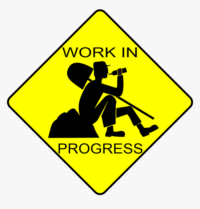

## THANKS. YOU HAVE MADE IT HERE....DONT FORGET TO UPVOTE IF YOU FIND IT USEFUL.......!!!!!!

**References:**

I am here to learn, pleaase let me know if I have missed anyone in my list. Happy to include. Please upvote original works developed by other kagglers listed below also.

https://www.kaggle.com/code/hasanbasriakcay/tps-mar22-pycaret-model-comparison

https://www.kaggle.com/ambrosm/tpsmar22-eda-which-makes-sense


https://www.kaggle.com/chaudharypriyanshu/febtabular-eda-fast-baseline

https://arxiv.org/pdf/1912.09363.pdf

https://www.kaggle.com/sytuannguyen/tps-mar-2022-eda-model

https://www.kaggle.com/martynovandrey/tps-mar-22-multioutput-cat-modeless

https://www.kaggle.com/luisblanche/pytorch-forecasting-temporalfusiontransformer

https://www.kaggle.com/shreyasajal/pytorch-forecasting-for-time-series-forecasting



